MotorwaySegment of "A2" with start Point(x=8.9287827, y=46.0685891) and end Point(x=8.928685, y=46.0680586). 	 epsg:4326
MotorwaySegment of "A2" with start Point(x=2715295.589739048, y=1102990.6704969718) and end Point(x=2715289.151463621, y=1102931.5637740814). 	 epsg:2056


/Users/cynthia/Document_local/geo877/data_Preprocessing.py:194: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  mway_ch_geometries_exp = mway_ch_geometries.explode()
/Users/cynthia/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


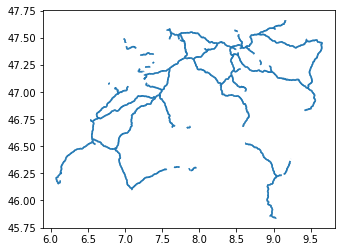

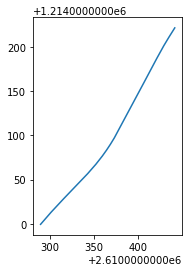

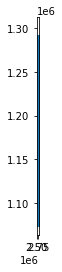

In [3]:
%run ./data_Preprocessing.py

In [4]:
# SETUP
# =====
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import time
from geospatial import *

In [5]:
class CellSegment(Segment):
    def __init__(self, start, end):
        super().__init__(start, end)
        self.name = name
        self.index1 = 0
        self.index2 = 0
    
    # Overwrite representation
    def __repr__(self):
        return f'MotorwaySegment of "{self.name}" with start {self.start} and end {self.end}, start cell in {self.index1} and end cell in {self.index2}.'
    


In [6]:
class CellLength():
    def __init__(self, data, box, res): # input: motorway_segments = [[...,start,end,...], ...]
        ## Assume data structure: [[start_point,end_point,...],...]
        self.data = data
        # Number of grid rows and colums
        self.res = res #res = resolution
        self.w = box.ur.x - box.ll.x
        self.h = box.ur.y - box.ll.y
        self.nCols = int(self.w/ self.res)+1 # because I set the bBox bigger, so I don't need to +1
        self.nRows = int(self.h/ self.res)+1
        
        ur = Point(box.ll.x + (self.nCols * self.res), box.ll.y + (self.nRows * self.res))
        ll = box.ll
        self.bBox = Bbox([ll, ur])
        
        # Cell with index to store the length
        self.maxIndex = (self.nCols * self.nRows) -1        
        i = 0
        self.cellLength = []
        while i <= self.maxIndex:
            self.cellLength.append(0)
            i += 1  
            
    def addIndex(self):
        for segment in self.data:
            segment.index1 = self.pointIndex(segment.start)  # add index of start point
            segment.index2 = self.pointIndex(segment.end)  # add index of end point   
    
    def pointIndex(self, p): # Define the which cell the point is in
        j = int((p.y - self.bBox.ll.y)/ self.res)
        i = int((p.x - self.bBox.ll.x)/ self.res)
        return (j * self.nCols) + i    

    def addLength(self):
        self.addIndex()
        for seg in self.data:
            if seg.index1 == seg.index2: # if in the same cell
                index = seg.index1
                self.cellLength[index] = self.cellLength[index] + self.segLength(seg.start,seg.end) # start_p, end_p
            else:
                point1 = seg.start
                point2 = seg.end
                index1 = seg.index1
                index2 = seg.index2
                
                j1 = int((point1.y - self.bBox.ll.y)/ self.res)
                i1 = int((point1.x - self.bBox.ll.x)/ self.res)
                j2 = int((point2.y - self.bBox.ll.y)/ self.res)
                i2 = int((point2.x - self.bBox.ll.x)/ self.res)

                min_x = min(point1.x, point2.x)
                max_x = max(point1.x, point2.x)
                min_y = min(point1.y, point2.y)
                max_y = max(point1.y, point2.y)
                
                min_i = min(i1,i2)
                max_i = max(i1,i2)
                min_j = min(j1,j2)
                max_j = max(j1,j2)
                
                k = (max_y - min_y)/(max_x - min_x)
                b = -k * point1.x + point1.y
                
                points = []
                points.append(point1)
                points.append(point2)
                
                while min_j < max_j: #!make sure if it is y
                    intersect_y = (min_j + 1)*self.res + self.bBox.ll.y # !make sure cells have the same size
                    intersect_x = (intersect_y - b)/k
                    point_new = Point(intersect_x,intersect_y)
                    points.append(point_new)
                    min_j = min_j + 1
                    #print(f"intersect_y:{intersect_y},intersect_x:{intersect_x}")
                    
                while min_i < max_i: #!make sure if it is x
                    intersect_x = (min_i + 1)*self.res + self.bBox.ll.x
                    intersect_y = k*intersect_x + b
                    point_new = Point(intersect_x,intersect_y)
                    points.append(point_new)
                    min_i = min_i + 1
                    #print(f"intersect_y:{intersect_y},intersect_x:{intersect_x}")
                
                points_r = []
                points_count = len(points)
                for n in range(points_count):
                    m = 0
                    p = 0
                    for i in range(len(points)):
                        if points[i].x > m:
                            m = points[i].x
                            p = i # store the point index
                    points_r.append(points[p])
                    points.pop(p) #delete list element 
                
                #for i in points_r:
                #    print(f"{i.x},{i.y}")
            
                #calculate length
                for i in range(len(points_r)-1):
                    start = points_r[i]
                    end = points_r[i+1]
                    seg_cellindex = self.pointIndex(points_r[i+1])
                    #print(seg_cellindex)
                    self.cellLength[seg_cellindex] = self.cellLength[seg_cellindex] + self.segLength(start,end)
    
    def segLength(self,p1,p2):  # calculate segment length
        
        return p1.distEuclidean(p2)
    
    
    

In [7]:
# put to main()
cellSegments = []
for segment in motorway_segments_transformed:
    cellSegment = CellSegment(segment.start,segment.end)
    cellSegments.append(cellSegment)



In [8]:
# create bounding box 
xs = 2250000
xf = 3000000
ys = 1075000
yf = 1300000

box = Bbox([Point(xs, ys), Point(xf, yf)])

# tset data
res = 100000
cellLength = CellLength(cellSegments, box, res)

print(f"cellLength.nCols: {cellLength.nCols}, cellLength.nRows: {cellLength.nRows}, cellLength.res: {cellLength.res},cellLength.maxIndex: {cellLength.maxIndex}")



cellLength.nCols: 8, cellLength.nRows: 3, cellLength.res: 100000,cellLength.maxIndex: 23


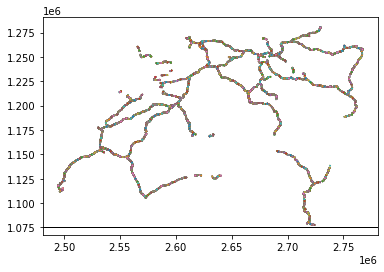

In [17]:
figure, axes = plt.subplots()
rect = plt.Rectangle((cellLength.bBox.ll.x,cellLength.bBox.ll.y), cellLength.w, cellLength.h, fill= False)

for seg in cellSegments:
    x1 = [seg.start.x, seg.end.x]
    y1 = [seg.start.y, seg.end.y]
    plt.plot(x1, y1)
    
#plt.xlim([xs-100, xf+100])
#plt.ylim([ys-100, yf+100])
#axes.set_aspect(1)
axes.add_artist(rect)
plt.show()

In [10]:
cellLength.addIndex()

for seg in cellLength.data:
    if seg.index1 != seg.index2:
        print(seg)

MotorwaySegment of "S1" with start Point(x=2689954.731595992, y=1174747.307485095) and end Point(x=2690188.2185010244, y=1175089.555480888), start cell in 4 and end cell in 12.
MotorwaySegment of "S1" with start Point(x=2690180.0355552235, y=1175093.2236782452) and end Point(x=2690093.7416463653, y=1174966.9832725914), start cell in 12 and end cell in 4.
MotorwaySegment of "S1" with start Point(x=2724990.940593408, y=1275022.3797584584) and end Point(x=2724897.3283795174, y=1274981.1703327417), start cell in 20 and end cell in 12.
MotorwaySegment of "S1" with start Point(x=2724947.7699894817, y=1274992.4040650076) and end Point(x=2725007.1403005198, y=1275018.7860930066), start cell in 12 and end cell in 20.
MotorwaySegment of "S1" with start Point(x=2749997.1746925223, y=1257813.118668798) and end Point(x=2750155.4403229402, y=1257964.7140175381), start cell in 12 and end cell in 13.
MotorwaySegment of "S1" with start Point(x=2750031.9818136212, y=1257865.1409512558) and end Point(x=2

In [11]:
cellLength.addLength()

cellLength.cellLength

[0,
 0,
 230040.20928499862,
 326462.4005506676,
 271134.60475392593,
 0,
 0,
 0,
 0,
 0,
 93118.77900487486,
 941020.9443387449,
 970166.9843114868,
 225099.19410472337,
 0,
 0,
 0,
 0,
 0,
 0,
 15592.038506834877,
 0,
 0,
 0]

In [12]:
# calcu_osm
cellSegments_osm = []
for segment in motorway_ch_segments:
    cellSegment_osm = CellSegment(segment.start,segment.end)
    cellSegments_osm.append(cellSegment_osm)
    
cellLength_osm = CellLength(cellSegments_osm, box, res)
cellLength_osm.addIndex()
cellLength_osm.addLength()
cellLength_osm.cellLength

[0,
 0,
 326137.1916014848,
 644222.2324491023,
 540969.0160641917,
 84143.29208679398,
 0,
 0,
 0,
 0,
 151001.54326338248,
 1512870.9250137154,
 1528403.02947608,
 371200.7652782359,
 0,
 0,
 0,
 0,
 0,
 0,
 75726.2396621874,
 0,
 0,
 0]

In [13]:
# compare
result1 = cellLength.cellLength
result2 = cellLength_osm.cellLength
result = []
for i in range(len(result1)):
    result.append(0)
    if cellLength.cellLength[i] != 0:
        result[i] = (result1[i] / result2[i])*100

result

[0,
 0,
 70.53479799571296,
 50.675432188916304,
 50.12017263512794,
 0,
 0,
 0,
 0,
 0,
 61.66743530723632,
 62.20100662785979,
 63.475861117865584,
 60.640821668564946,
 0,
 0,
 0,
 0,
 0,
 0,
 20.59000760686192,
 0,
 0,
 0]

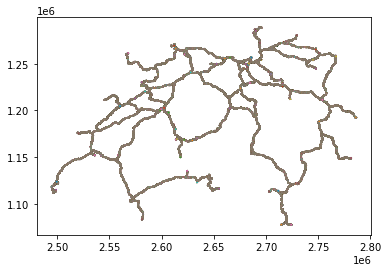

In [14]:
#figure, axes = plt.subplots()
#rect = plt.Rectangle((cellLength.bBox.ll.x,cellLength.bBox.ll.y), cellLength.w, cellLength.h, fill= False)

for seg in cellSegments_osm:
    x1 = [seg.start.x, seg.end.x]
    y1 = [seg.start.y, seg.end.y]
    plt.plot(x1, y1)
    
#plt.xlim([xs-1, xf+1])
#plt.ylim([ys-1, yf+1])
#axes.set_aspect(1)
#axes.add_artist(rect)
plt.show()